# Course Project: Wildfire Analysis (Part 1: Common Analysis)

## Predictive Modeling and Smoke Analysis

More and more frequently summers in the western US have been characterized by wildfires with smoke billowing across multiple western states. There are many proposed causes for this: climate change, US Forestry policy, growing awareness, just to name a few. Regardless of the cause, the impact of wildland fires is widespread as wildfire smoke reduces the air quality of many cities. There is a growing body of work pointing to the negative impacts of smoke on health, tourism, property, and other aspects of society.

The Course Project is designed to analyze the impacts of wildfires on specific cities in the United States, particularly focusing on the effects of wildfire smoke and its implications for public health, air quality, and overall community well-being.

This is the first step in the project, where all the students conduct a base analysis using a shared dataset while focusing on a unique city. The aim is to create an understanding of wildfire impacts tailored to local contexts.

In this notebook, we use an ARIMA model to forcast smoke estimates for the next 25 years. We also see the relationship betweem AQI and smoke estimates and list down the observations. Additionally, we also visualizes fire frequency, intensity, and total acres burned within 1800 miles of Vancouver, underscoring the need for further model refinement and alternative metrics for a more comprehensive assessment of wildfire impacts.

## 1. Import libraries and required dependencies

In [1]:
# !pip install statsmodel

In [38]:
# import pandas and numpy- for data analysis
import pandas as pd
import numpy as np

# import a few libraries to create visualizations
import matplotlib.pyplot as plt

# for predictive modeling
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# for comparing Smoke estimate with AQI values
from scipy.stats import spearmanr

# suppress the warnings
import warnings
warnings.filterwarnings("ignore")

I have been assigned to analyse the city: Vancouver, WA for my analysis
- 2023 estimate: 196442
- 2020 census: 190915
- 2020 density: 3920
- Latitude/Longitude: 45.64°N 122.60°W

In [43]:
# CONSTANTS
FIRE_DATE_RAWDATA_PATH = "../data/intermediate_data/wildfire_dataset_with_distance.csv"
FIRE_YEAR_DATA_PATH = "../data/intermediate_data/wildfire_dataset_with_distance_and_smoke_estimate_by_year.csv"
FIRE_DATE_DATA_PATH = "../data/intermediate_data/wildfire_dataset_with_distance_and_smoke_estimate_by_date.csv"
AQI_DATA_PATH = "../data/intermediate_data/aqi_data_grouped_by_year.csv"

# A dictionary of the city location from the US west coast state.
CITY_LOCATIONS = {
    'vancouver' :   {'city'   : 'Vancouver',
                    'latlon' : [45.64, -122.60] }
}

## 2. Load the datasets

In [44]:
# Load the fire data that has the smoke estimate
wildfire_df = pd.read_csv(FIRE_YEAR_DATA_PATH)
wildfire_df.drop("Unnamed: 0", axis = 1, inplace=True)
wildfire_df.head()

,year,smoke_estimate_scaled,Mean_GIS_SqMiles,Mean_average_distance
0,1961,5.704264,2.112677,430.484837
1,1962,2.064932,0.839785,475.337610
2,1963,7.274286,2.346199,401.233279
3,1964,5.476086,2.354631,360.510278
4,1965,2.190371,0.954739,454.041410


In [45]:
# Load the raw fire data that has the smoke estimate (by date)
wildfire_df_without_cutoff_distance = pd.read_csv(FIRE_DATE_RAWDATA_PATH)
wildfire_df_without_cutoff_distance.drop("Unnamed: 0", axis = 1, inplace=True)
wildfire_df_without_cutoff_distance.head()

,OBJECTID,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,Fire_Polygon_Tier,Fire_Attribute_Tiers,GIS_Acres,GIS_Hectares,Source_Datasets,Listed_Fire_Types,...,Wildfire_Notice,Prescribed_Burn_Notice,Wildfire_and_Rx_Flag,Overlap_Within_1_or_2_Flag,Circleness_Scale,Circle_Flag,Exclude_From_Summary_Rasters,Shape_Length,Shape_Area,average_distance
0,13526,13526,Wildfire,1961.0,1,"1 (4), 3 (6)",55249.740141,22358.776573,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (8), Likely Wildfire (2)",...,Wildfire mapping prior to 1984 was inconsisten...,Prescribed fire data in this dataset represent...,NaN,NaN,0.398775,NaN,No,83939.248629,2.235878e+08,369.362521
1,13527,13527,Wildfire,1961.0,1,"1 (4), 3 (6)",43920.841077,17774.133779,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (8), Likely Wildfire (2)",...,Wildfire mapping prior to 1984 was inconsisten...,Prescribed fire data in this dataset represent...,NaN,"Caution, this Wildfire in 1961 overlaps with a...",0.304477,NaN,No,85648.862830,1.777413e+08,596.735456
2,13528,13528,Wildfire,1961.0,1,"1 (4), 3 (6)",34233.698603,13853.886306,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (8), Likely Wildfire (2)",...,Wildfire mapping prior to 1984 was inconsisten...,Prescribed fire data in this dataset represent...,NaN,NaN,0.320032,NaN,No,73755.413582,1.385389e+08,505.921210
3,13529,13529,Wildfire,1961.0,1,"1 (2), 3 (3)",32866.053451,13300.419949,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (4), Likely Wildfire (1)",...,Wildfire mapping prior to 1984 was inconsisten...,Prescribed fire data in this dataset represent...,NaN,NaN,0.481665,NaN,No,58906.755757,1.330042e+08,584.054693
4,13530,13530,Wildfire,1961.0,1,"1 (1), 3 (2)",27269.045936,11035.391368,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (2), Likely Wildfire (1)",...,Wildfire mapping prior to 1984 was inconsisten...,Prescribed fire data in this dataset represent...,NaN,NaN,0.433246,NaN,No,56575.916692,1.103539e+08,166.864775


In [46]:
# Load the fire data that has the smoke estimate (by date)
wildfire_df_by_date = pd.read_csv(FIRE_DATE_DATA_PATH)
wildfire_df_by_date.drop("Unnamed: 0", axis = 1, inplace=True)
wildfire_df_by_date.head()

,OBJECTID,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,Fire_Polygon_Tier,Fire_Attribute_Tiers,GIS_Acres,GIS_Hectares,Source_Datasets,Listed_Fire_Types,...,First_Listed_Fire_Month,Assigned_Fire_Type_Label,Listed_Fire_Cause_Class_cleaned,Listed_Fire_Cause_Class_cleaned_Label,GIS_SqMiles,average_distance_SqMiles,log_average_distance,log_GIS_SqMiles,smoke_estimate,smoke_estimate_scaled
0,13526,13526,Wildfire,1961,1,"1 (4), 3 (6)",55249.740141,22358.776573,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (8), Likely Wildfire (2)",...,9.0,1.0,Undetermined,0,86.327719,136428.671790,11.823565,4.469668,0.233721,233.720841
1,13528,13528,Wildfire,1961,1,"1 (4), 3 (6)",34233.698603,13853.886306,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (8), Likely Wildfire (2)",...,9.0,1.0,Undetermined,0,53.490154,255956.270402,12.452766,3.998020,0.105728,105.728230
2,13529,13529,Wildfire,1961,1,"1 (2), 3 (3)",32866.053451,13300.419949,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (4), Likely Wildfire (1)",...,7.0,1.0,Undetermined,0,51.353209,341119.884354,12.739992,3.958013,0.087925,87.925342
3,13530,13530,Wildfire,1961,1,"1 (1), 3 (2)",27269.045936,11035.391368,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (2), Likely Wildfire (1)",...,9.0,1.0,Undetermined,0,42.607884,27843.853067,10.234403,3.775238,0.255344,255.343792
4,13533,13533,Wildfire,1961,1,"1 (1), 3 (3)",13511.581889,5467.943194,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (2), Likely Wildfire (2)",...,7.0,1.0,Undetermined,0,21.111847,147717.040721,11.903061,3.096114,0.054930,54.930168


In [47]:
# Load the AQI data
aqi_df = pd.read_csv(AQI_DATA_PATH)
aqi_df.drop("Unnamed: 0", axis = 1, inplace=True)
aqi_df.head()

,year,AQI
0,1990,54.318966
1,1991,52.859375
2,1992,56.285714
3,1993,47.426230
4,1994,49.564516


## 3. Compare the estimated smoke impact to AQI 

First, we will merge both the datasets by year

In [48]:
smoke_aqi_df = pd.merge(wildfire_df, aqi_df, on='year')
display(smoke_aqi_df)

,year,smoke_estimate_scaled,Mean_GIS_SqMiles,Mean_average_distance,AQI
0,1990,7.412804,2.250458,355.356059,54.318966
1,1991,4.301184,1.193496,339.093160,52.859375
2,1992,9.453330,3.293378,382.160408,56.285714
3,1993,1.458284,0.441502,315.302579,47.426230
4,1994,16.492413,4.875427,371.578427,49.564516
5,1995,5.716198,2.459122,416.449250,41.983607
6,1996,17.346514,6.047522,391.610381,45.836066
7,1997,3.362726,0.852566,374.088528,61.096774
8,1998,5.413723,1.812621,371.256655,52.163934
9,1999,15.921199,6.589946,409.592637,60.183176


Next, let's plot and compare

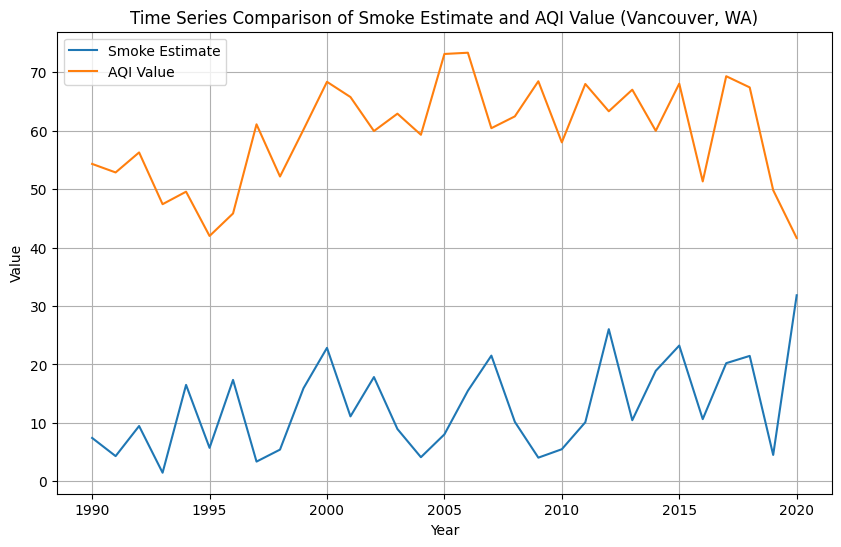

In [49]:
plt.figure(figsize=(10, 6))
plt.plot(smoke_aqi_df['year'], smoke_aqi_df['smoke_estimate_scaled'], label='Smoke Estimate')
plt.plot(smoke_aqi_df['year'], smoke_aqi_df['AQI'], label='AQI Value')
plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Time Series Comparison of Smoke Estimate and AQI Value (Vancouver, WA)')
plt.grid()
plt.legend()
plt.show()

I am not able to say how similar are both the values. I thought maybe I will see how well they are correlated with each other.

In [8]:
# Calculate Spearman correlation
spearman_corr, p_value = spearmanr(smoke_aqi_df['smoke_estimate_scaled'], smoke_aqi_df['AQI'])
print("Spearman Correlation between Smoke Estimate and AQI: ", spearman_corr)
print("P-value: ", p_value)

Spearman Correlation between Smoke Estimate and AQI:  0.2270161290322581
P-value:  0.21939342327301325


The Spearman correlation coefficient between the Smoke Estimate and the Air Quality Index (AQI) is ~0.23. This indicates a weak positive correlation, suggesting that as the Smoke Estimate increases, the AQI tends to increase slightly, but the relationship is not strong. The p-value of ~0.22 suggests that this correlation is not statistically significant, indicating that we cannot confidently reject the null hypothesis that there is no correlation between the two measures.

### 3.1 Air Quality Index (AQI):
- The AQI is designed to communicate the overall air quality status based on the concentration of five major pollutants: ground-level ozone, particulate matter (PM10 and PM2.5), carbon monoxide, sulfur dioxide, and nitrogen dioxide. It sums up these pollutants' values into a single score reflecting health risks associated with poor air quality.
    - It is calculated by converting measured pollutant concentrations to a uniform index based on health benchmarks established by the EPA. This calculation often prioritizes the pollutant with the highest AQI value, meaning the overall AQI reflects the pollutant that poses the greatest immediate health risk at that time or location.
    - Fire smoke comprises a complex mixture of gases and fine particulate matter, primarily PM2.5, which is notably harmful to health due to its ability to penetrate deep into the lungs and enter the bloodstream. The interplay between fire smoke and AQI measures is critical; while PM2.5 from smoke contributes significantly to AQI values, other factors such as weather conditions, geographical location, and time of year can also influence how AQI is reported.

References:
- [airnow-AQI](https://www.airnow.gov/aqi/aqi-basics/)
- [Air Quality Index](https://www.lung.org/clean-air/outdoors/air-quality-index)
- [Wildfire Smoke and Your Patients' Health: The Air Quality Index](https://www.epa.gov/wildfire-smoke-course/wildfire-smoke-and-your-patients-health-air-quality-index)
- [Wildfire Smoke](https://dph.illinois.gov/topics-services/environmental-health-protection/wildfire-smoke.html)

### 3.2 Inference:
- The weak correlation might be due to various reasons. For example, the AQI does not account for localized air quality events, and its data is derived from various monitoring stations that may not be optimally positioned to capture the specific impacts of wildfire smoke. Also, the AQI’s focus on aggregate levels may mask more localized spikes in particulate matter concentration that could be significantly influenced by nearby wildfires.
- When analyzing smoke estimates against AQI, it is crucial to consider that while higher AQI values may occur during active wildfire events, the correlations may dilute compared to periods of lower smoke impact, where other pollutants may dominate the AQI readings. It would also be beneficial to explore additional metrics beyond just the AQI, such as specific PM2.5 levels during wildfire instances, to gain a more better understanding of air quality impacts.
- Also, the Smoke Estimate is a manually calculated by me and it lacks accuracy. This estimate does not account for many factors influencing smoke levels and was derived intuitively by making several assumptions. Be cautious when interpreting these results, as they do not provide an accurate measurement of the impacts of smoke!

## 4. Predictive Modeling

In this step, we will develop a predictive model based on the fire data and smoke estimate for the assigned city. 
The model should predict smoke estimates for every year for the next 25 years (i.e., 2025-2050). 

Time forecasting models are statistical and machine learning techniques used to predict future values based on historical time-series data. Statistical models like, ARIMA (AutoRegressive Integrated Moving Average), SARIMA (Seasonal ARIMA), Exponential Smoothing (ETS), Machine Learning Models like, Linear/Polynomial Regression, Decision Trees, Boosting Models, SVMs, RNNs, LSTMs, Transformers, and Hybrid models such as ARIMA-LSTM are some example.

ARIMA (AutoRegressive Integrated Moving Average) is a robust model specifically designed for analyzing and forecasting time series data. It is capable of modeling trends (e.g., increasing smoke estimates over the years), particularly through its differencing parameter (d) which helps in achieving stationarity. They incorporate both autoregressive (past values) and moving average (past forecast errors) components, allowing it to capture complex relationships in the data that simpler models may overlook. ARIMA is grounded in solid statistical theory, providing a credible basis for forecasts. The ability to produce confidence intervals for predictions is a crucial feature of ARIMA. They can be fine-tuned by adjusting the parameters (p, d, q) to optimize performance according to the specific characteristics of our data and with readily available libraries (e.g., Statsmodels in Python), implementing ARIMA models is straightforward.
In this project, I did not explore any other models in depth. I will be using ARIMA for wildfire smoke estimate prediction.


### 4.1 Data Preprocessing

In [74]:
# set 'Year' as the index
wildfire_df.set_index('year', inplace=True)

I majorly referred to this [ARIMA tutorial](https://www.datacamp.com/tutorial/arima) to understand the steps in preprocessing.

In time series forecasting, stationarity means that the statistical properties of the data, like mean and variance, do not change over time. Stationary data is often easier to model accurately because it's predictable and consistent in its patterns, while non-stationary data can be much harder to predict due to its trends or varying volatility.

Keeping things stationary makes the modeling task a lot easier, helps to improve our model accuracy and in return provides us with more reliable predictions. While ARIMA models can deal with non-stationarity up to a point, they cannot effectively account for time-varying variance. Here we can use the Augmented Dickey-Fuller test to tell us if our data has a constant mean and variance.

Reference: 
- [Augmented Dickey-Fuller test](https://en.wikipedia.org/wiki/Augmented_Dickey–Fuller_test)

In [10]:
result = adfuller(wildfire_df['smoke_estimate_scaled'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: 0.0037668638252659403
p-value: 0.9588424966485521


Inference:
- ADF Statistic = 0.0038: The ADF statistic value is very close to zero, which generally implies a lack of evidence to support the presence of stationarity within the series. For a series to be stationary, we typically expect the ADF statistic to be significantly negative.
- p-value = 0.9588: This high p-value (much greater than common significance levels such as 0.05) indicates that we cannot reject the null hypothesis that the series is non-stationary. A p-value of this magnitude suggests that there is substantial evidence indicating that the series may contain trends or other time-dependent properties.

There are many methods to transform the data into a stationary series, for example, Differentiating and Performing transformations.

Differencing or Differentiating involves subtracting the previous data point from the current data point. The first difference can often eliminate trends and stabilize the mean of the series over time. I will try differentiating and then re-run the ADF test.

In [11]:
wildfire_df["smoke_estimate_scaled_diff"] = wildfire_df["smoke_estimate_scaled"].diff()
wildfire_df.dropna(subset=["smoke_estimate_scaled_diff"], inplace=True)

result = adfuller(wildfire_df['smoke_estimate_scaled_diff'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -7.419187916931178
p-value: 6.807390249127112e-11


Inference: 
- ADF Statistic: -7.42: This value is significantly negative, far below zero. In general, more negative ADF statistics indicate stronger evidence against the null hypothesis of non-stationarity. A value this low suggests that the time series is likely stationary.
- p-value: 9.43e-11: This p-value is exceedingly low, much lower than even the significance level of 0.05. A p-value this small provides strong evidence to reject the null hypothesis of non-stationarity, indicating that the series does not exhibit a unit root and likely shows stationarity.

Hence, in this case, we can say that the differencing process successfully transformed the "smoke_estimate_scaled" series into a stationary series.​ 

### 4.2 Model Identification

When we build an ARIMA model, we have to consider the p, d, and q terms that go into our ARIMA model. 
- The first parameter, p, is the number of lagged observations. By considering p, we effectively determine how far back in time we go when trying to predict the current observation. We do this by looking at the autocorrelations of our time series, which are the correlations in our series at previous time lags. 
- The second parameter, d, refers to the order of differencing. Differencing simply means finding the differences between consecutive timesteps. It is a way to make our data stationary, which means removing the trends and seasonality. d indicates differencing at which order you get a process stationary.
- The third parameter q refers to the order of the moving average (MA) part of the model. It represents the number of lagged forecast errors included in the model. Unlike a simple moving average, which smooths data, the moving average in ARIMA captures the relationship between an observation and the residual errors from a moving average model applied to lagged observations.

To find the best p, d, and q values, we will systematically perform hyperparameter tuning. 
- We have nested loops to iterate through every parameter combination
- We perform cross-validation to compute the average RMSE for each configuration across five folds of the dataset.
    - During each fold, we separates the data into training and testing sets before fitting the ARIMA model and calculating the RMSE. 
    - Results are stored, and the best-performing parameter set is tracked based on the lowest mean RMSE.

Code/Concept References:
- [what are the values p,d,q in arima](https://stats.stackexchange.com/questions/44992/what-are-the-values-p-d-q-in-arima)
- [a guide to parameter tuning in auto arima function for time series forecasting](https://medium.com/@aysuudemiir/a-guide-to-parameter-tuning-in-auto-arima-function-for-time-series-forecasting-aec50fb1523a)
- [grid search arima hyperparameters with python](https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/)
- [using k-fold validation for time series model selection](https://stats.stackexchange.com/questions/14099/using-k-fold-cross-validation-for-time-series-model-selection)

In [77]:
def fit_arima(train_data, test_data, order):
    """
    Fit an ARIMA model to the training data and calculate RMSE for the forecasted values.

    Parameters:
    - train_data: DataFrame containing the training dataset with a 'Smoke_estimate' column.
    - test_data: DataFrame containing the test dataset with a 'Smoke_estimate' column.
    - order: Tuple representing the (p, d, q) parameters of the ARIMA model.

    Returns:
    - rmse: The root mean squared error of the model predictions.
    """
    
    # Select only the 'Smoke_estimate' column for modeling
    train_series = train_data['smoke_estimate_scaled']
    test_series = test_data['smoke_estimate_scaled']
    
    # Fit the ARIMA model
    arima_model = ARIMA(train_series, order=order)
    model_fit = arima_model.fit()
    
    # Forecast the values for the length of the test set
    forecasted_values = model_fit.forecast(steps=len(test_series))
    
    # Calculate the RMSE between the actual and forecasted values
    rmse = np.sqrt(mean_squared_error(test_series, forecasted_values))
    
    return rmse

In [78]:
arima_results = []
best_rmse = float('inf')
best_order = None

num_folds = 5 
fold_size = len(wildfire_df) // num_folds  # calculate the size of each fold

# define ranges for p, d, and q parameters - I have kept d to be minimum 1.
p_values = range(1, 10)
d_values = range(1, 4)
q_values = range(1, 10)


for p_param in p_values:
    for d_param in d_values:
        for q_param in q_values:
            try:
                total_rmse = 0 # initialize the cumulative RMSE for cross-validation folds
                
                # perform cross-validation
                for fold in range(num_folds):
                    start_idx = fold * fold_size # define the training and testing indices for the current fold
                    end_idx = (fold + 1) * fold_size
                    
                    # split the data into training and testing sets
                    test_set = wildfire_df[start_idx:end_idx]
                    train_set = pd.concat([wildfire_df[:start_idx], wildfire_df[end_idx:]])
                    
                    # fit ARIMA model and calculate RMSE for the current fold
                    fold_rmse = fit_arima(train_set, test_set, order=(p_param, d_param, q_param))
                    total_rmse += fold_rmse
                
                # calculate the average RMSE for this parameter combination
                mean_rmse = total_rmse / num_folds
                arima_results.append((p_param, d_param, q_param, mean_rmse))
                
                # check if this is the best RMSE found so far
                if mean_rmse < best_rmse:
                    best_rmse = mean_rmse
                    best_order = (p_param, d_param, q_param)
            except:
                continue


In [127]:
print("Optimal ARIMA configuration: ", best_order)
print("Lowest average RMSE obtained:", best_rmse)

Optimal ARIMA configuration:  (6, 1, 3)
Lowest average RMSE obtained: 7.461543747502799


The optimal ARIMA configuration identified for the model is (6, 1, 3):
- p = 6: Model includes six lagged observations of the dependent variable in predicting future values. The autoregressive component (AR) captures the relationship between the current observation and its previous four values, allowing the model to use more information from the recent past.
- d = 1: Model applies first differencing to the time series data to achieve stationarity. Differencing one times removes trends and seasonality from the data, effectively making the series stationary for better model performance.
- q = 3: Model incorporates three lagged forecast errors in its predictions. The moving average component (MA) helps to account for the influence of past error terms on the current observation.

It looks like the model is applying d=1 by itself. So, we will proceed with the `smoke_estimate_scaled` term.

### 4.3 Model Fitting
Now let us fit the model with these optimal configuration.

In [137]:
def arima_fit_and_predict(data, model_order, num_steps):
    
    arima_model = ARIMA(data, order=model_order)
    model_results = arima_model.fit()
    
    predictions = model_results.forecast(steps=num_steps) # predict future values
    residuals = model_results.resid
    standard_error = np.std(residuals) # compute the standard error using the residuals
    
    # calculate confidence intervals (95% confidence interval)
    lower_limits = predictions - 1.96 * standard_error
    upper_limits = predictions + 1.96 * standard_error
    
    return model_results, predictions, standard_error, lower_limits, upper_limits

In [140]:
# fit the model
data = wildfire_df['smoke_estimate_scaled']
train_data, test_data = train_test_split(data, test_size=0.2, random_state=29)
train_size = int(len(data) * 0.8)
arima_model_fit, predicted_smoke, error, lower_bound, upper_bound = arima_fit_and_predict(train_data, 
                                                                                        best_order,
                                                                                        len(test_data))

### 4.4 Model Performance

To forecast using an ARIMA model, start by using the fitted model to predict future values based on the data. Once predictions are made we can visualize them by plotting the predicted values alongside the actual values. This is accomplished because we use a train/test workflow, where the data is split into training and testing sets. Doing this lets us see how well the model performs on unseen data. 

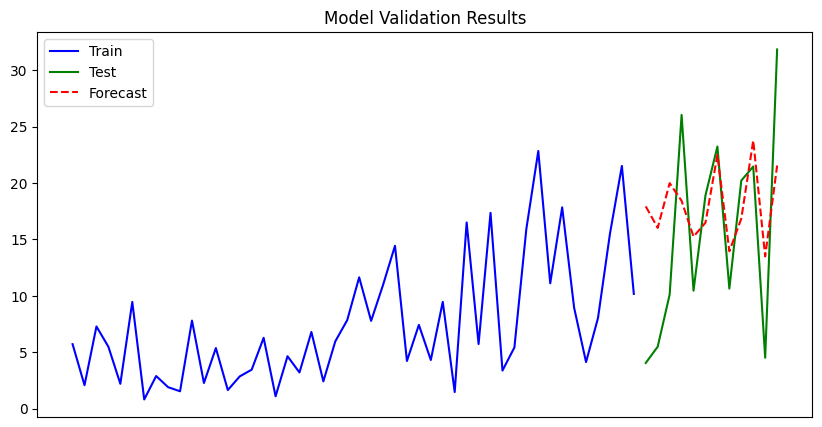

In [130]:
# forcast the data on the test set first
test_predicted_smoke = arima_model_fit.forecast(steps=len(test_data))
train_size = int(len(data) * 0.8)
plt.figure(figsize=(10, 5))
plt.plot(data.index[:train_size], train_data, label='Train', color='blue')
plt.plot(data.index[train_size:], test_data, label='Test', color='green')
plt.plot(data.index[train_size:], test_predicted_smoke, label='Forecast', color='red', linestyle='--')
plt.xticks([])
plt.legend()
plt.title('Model Validation Results')
plt.show()

The lowest average RMSE (Root Mean Square Error) obtained using this best order is ~7.46.​ When interpreted on this scale (0-30), the model's prediction errors are relatively low, given the narrower range of possible values. This indicates that while some errors occur, they remain manageable within this defined scale.

### 4.5 Forcasting
Now let us forcast for the next 50 years.

In [ ]:
num_forecast_years = 25  # Number of years to forecast

# fit the model
arima_model_fit, predicted_smoke, error, lower_bound, upper_bound = arima_fit_and_predict(wildfire_df['smoke_estimate_scaled'], 
                                                                                        best_order,
                                                                                        num_forecast_years)

In [131]:
forecast_wildfire_df = pd.DataFrame({'year': range(2025, 2050),
                                'predicted_smoke': predicted_smoke,
                                'lower_limit': lower_bound,
                                'upper_limit': upper_bound})
forecast_wildfire_df.reset_index(drop=True, inplace=True)
forecast_wildfire_df.head()

,year,predicted_smoke,lower_limit,upper_limit
0,2025,15.237470,4.654330,25.820610
1,2026,16.474233,5.891093,27.057373
2,2027,22.494151,11.911011,33.077291
3,2028,13.936329,3.353189,24.519469
4,2029,16.835378,6.252238,27.418517


To visualize better, let us plot the forcasted results alongside the historical data.

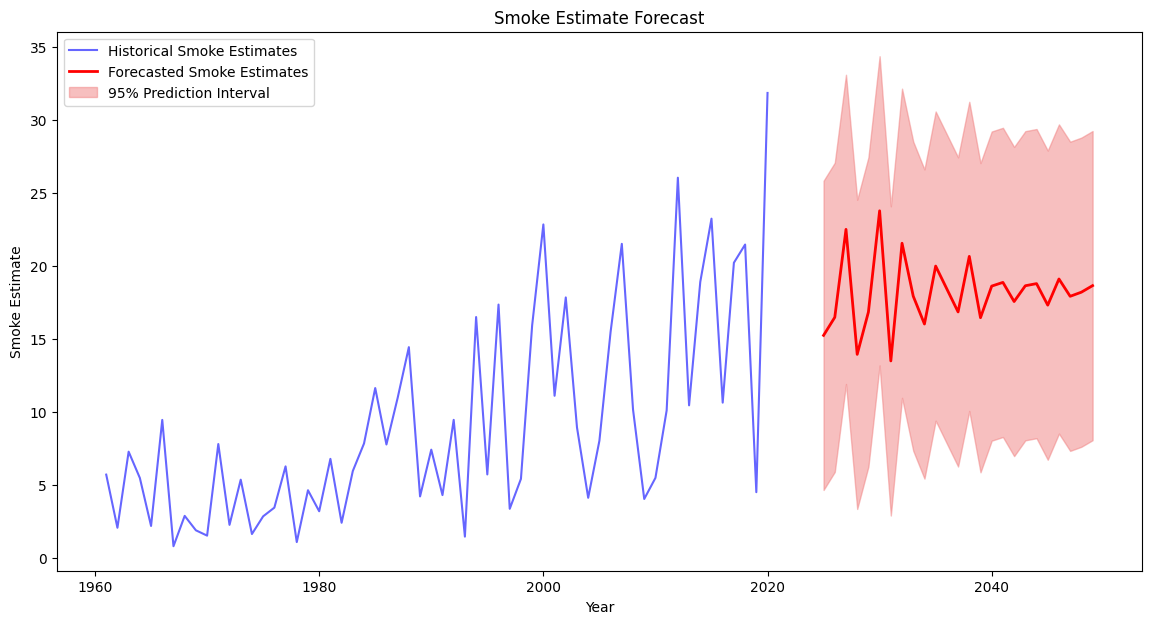

In [134]:
plt.figure(figsize=(14, 7))

# plot the historical data
plt.plot(wildfire_df.index, wildfire_df['smoke_estimate_scaled'], label='Historical Smoke Estimates', color='blue', alpha=0.6)

# plot the forcasted data
plt.plot(forecast_wildfire_df['year'], forecast_wildfire_df['predicted_smoke'], label='Forecasted Smoke Estimates', color='red', linewidth=2)

# have the prediction intervals
plt.fill_between(forecast_wildfire_df['year'], forecast_wildfire_df['lower_limit'], forecast_wildfire_df['upper_limit'], color='lightcoral', alpha=0.5, label='95% Prediction Interval')

plt.title('Smoke Estimate Forecast')
plt.xlabel('Year')
plt.ylabel('Smoke Estimate')
plt.legend()
plt.show()

Observations:
- The blue line shows significant fluctuations in smoke estimates from the 1960s to the early 2020s in Vancouver, WA. This suggests that smoke levels have varied considerably over the past decades.

- While there are ups and downs, there seems to be a general upward trend in smoke estimates, especially towards the end of the historical period. This could indicate that smoke levels have been increasing over time.

- The red line represents the forecasted smoke estimates from 2025 to 2050. It shows a continued upward trend, suggesting that smoke levels are expected to increase further in the future. The reasons for this trend could be various factors such as climate change, increased wildfires, or changes in human activities.

- The shaded area represents the 95% prediction interval. This means that there is a 95% chance that the actual smoke estimates will fall within this range. The widening of the interval towards the end of the forecast period indicates increasing uncertainty in the predictions.


Further Considerations:
- The accuracy of the interpretations depends on the quality of the data used to create the chart. Factors like data collection methods, measurement accuracy, and the representativeness of the sample can influence the conclusions. The smoke estimate used in this analysis is computed intuitively and it might not reflect the real-world results. 

- The chart only considers smoke estimates. Other factors like air quality regulations, technological advancements, and changes in land use patterns can also impact air quality and smoke levels.

- I only explored ARIMA in this project. Other existing models might give better accuracy for this dataset. Extensive model selection methods should be performed.

## 5. Smoke Analysis

### 5.1 Question
Produce a histogram showing the number of fires occurring every 50 mile distance from your assigned city for all fires ranging up to 1800 miles away from your assigned city. The histogram should indicate the distance cut-off for your modeling work as specified in Step 1.

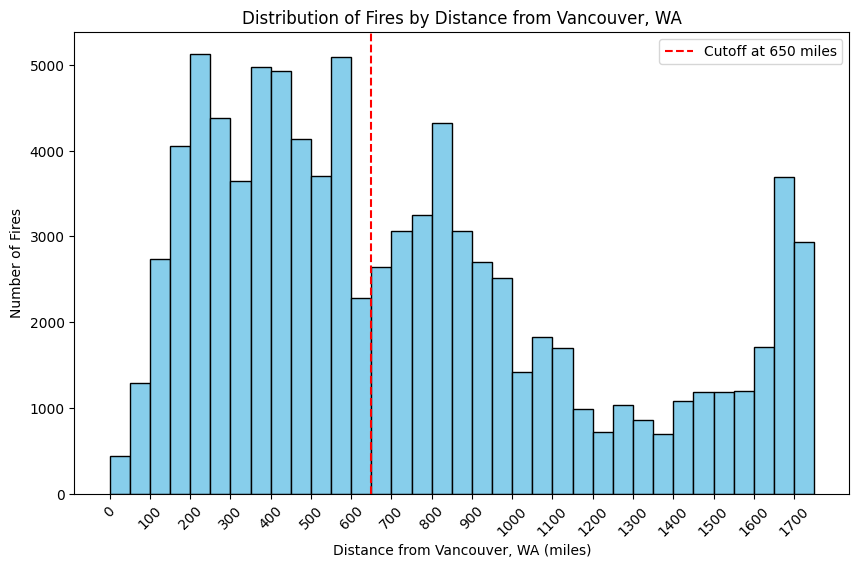

In [42]:
distance_bins = np.arange(0, 1800, 50)
cutoff_distance = 650

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(wildfire_df_without_cutoff_distance['average_distance'], bins=distance_bins, color='skyblue', edgecolor='black')
plt.axvline(x=cutoff_distance, color='red', linestyle='--', label=f'Cutoff at {cutoff_distance} miles') # add a red dashed line for the distance cutoff
plt.xlabel('Distance from Vancouver, WA (miles)')
plt.ylabel('Number of Fires')
plt.title('Distribution of Fires by Distance from Vancouver, WA')
plt.xticks(range(0, 1800, 100), rotation=45)
plt.legend()
plt.show()

### 5.2 Question
Produce a time series graph of total acres burned per year for the fires occurring in the specified distance from your city.

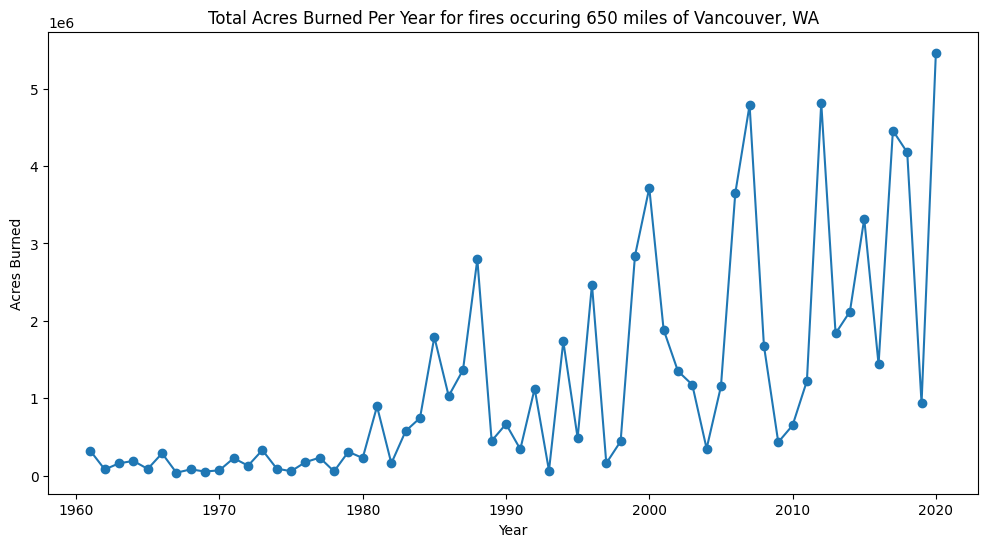

In [37]:
yearly_acres_burned = wildfire_df_by_date.groupby('Fire_Year')['GIS_Acres'].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(yearly_acres_burned['Fire_Year'], yearly_acres_burned['GIS_Acres'], marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Acres Burned')
plt.title('Total Acres Burned Per Year for fires occuring 650 miles of Vancouver, WA')
plt.show()

### 5.3 Question

Produce a time series graph containing your fire smoke estimates for your city and the AQI estimates for your city.

- Already produced in #3 of this notebook